# Import Libraries

In [51]:
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from itertools import groupby
import math
import neurokit2 as nk
from datetime import datetime
import json
import re
from scipy.stats import linregress
import os 
from itertools import product
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, lfilter
import time


# https://neuropsychology.github.io/NeuroKit/functions/eog.html

In [2]:
def column_str_to_float(data, column_names_arr): 
    # Remove non-numeric characters using regex
    for col_name in column_names_arr: 
        data[col_name] = pd.to_numeric(data[col_name], errors='coerce')
        
def parse_datetime(cell_value):
    try: 
        cleaned_value = cell_value.strip('"')
    except: 
        pass
    return datetime.strptime(cleaned_value, '%Y-%m-%d %H:%M:%S.%f')

def extract_name(json_str):
    try:
        label_dict = json.loads(json_str)
        if 'label' in label_dict:
            if isinstance(label_dict['label'], dict) and 'instruction' in label_dict['label']:
                return label_dict['label']['instruction'].get('name')
    except json.JSONDecodeError:
        pass
    return None

def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4): #1.5, 15
    """
    Apply butterworth + forward-backward digital filter on a given data column.
    Return np.array of that filtered data.

    :param data_col: np.array. Columns that only contains values from channel of interest. Shape: (500,)
    :param sr : int. Sampling Frequency (Hz)
    :param low_cut : float
    :param highcut : float
    :param order : int. Order of the filter
    """
    sos = scipy.signal.butter(order, [lowcut, highcut], btype="bandpass", output="sos", fs=sr)
    filtered = scipy.signal.sosfiltfilt(sos, data_col)
    return filtered

def detrend_data_linregress_new(prepared_data_channels): 
    # Fit a linear regression model
    
    time = prepared_data_channels["time_seconds"]
    
    for channel in ['eeg0', 'eeg1', 'eog0']:
        signal = prepared_data_channels[channel]
        slope, intercept, _, _, _ = linregress(time, signal)
        # Remove the linear trend
        detrended_signal = signal - (slope * time + intercept)
        prepared_data_channels[channel] = detrended_signal
        print(slope)
        print(intercept)

    return prepared_data_channels

def read_data_study_normalize(subject_name, study_number, normalize_order): 
    """
    @subject_name (string)
    @study_number (int)
    @normalize_order (int)
    """
    data_channels = pd.read_csv('data/attentivU/'+str(subject_name)+'/'+str(study_number)+'/exg0.csv')
    study_labels = pd.read_csv('study/'+ str(subject_name)+'/'+str(study_number)+'/events.csv')

    study_labels.rename(columns={study_labels.columns[0]: 'timestamp'}, inplace=True)
    study_labels['timestamp'] = pd.to_datetime(study_labels['timestamp'].str.strip('"'), format='%Y-%m-%d %H:%M:%S.%f')
    basetime = study_labels['timestamp'].min()
    study_labels['time_seconds'] = (study_labels['timestamp'] - basetime).dt.total_seconds()
    
    data_channels_prepared, data_channels_time = data_detrend(data_channels, normalize_order, basetime)
    
    return data_channels_prepared, data_channels_time, study_labels #basetime

def detrend_data_new(data, order): 
    """
    Polyfit data with specified order and detrend each channel 
    """
    detrended_data = data.copy()
    indices = np.arange(len(detrended_data))
    
    for channel in ['eeg0', 'eeg1', 'eog0']:
        detrended_data[channel] = detrended_data[channel].interpolate(method='linear')
        coefficients = np.polyfit(indices, detrended_data[channel], order)
        trend = np.polyval(coefficients, indices)
        detrended_data[channel] = detrended_data[channel] - trend
    return detrended_data

# 1. Read in all data

### Get same subject, different session data and merge the data 

In [3]:
def load_data_all_new(folder_path): 
    # Read in signal data and study labels
    
    subject_data_dict= {}
    subject_study_dict = {}
    
    for sub_folder in os.listdir(folder_path): 
        if sub_folder.startswith("sub") and os.path.isdir(os.path.join(folder_path, sub_folder)):
            # Extract subjet and session information
            parts= str(sub_folder)[3:].split("s")
            subj_number, session_num = int(parts[0]), int(parts[1])
            
            # Create a key for the subject in the dictionary 
            if subj_number not in subject_data_dict: 
                subject_data_dict[subj_number] = [] 
            if subj_number not in subject_study_dict: 
                subject_study_dict[subj_number] = [] 
            
            data_csv_path = os.path.join(folder_path, sub_folder, "data.csv")
            study_csv_path = os.path.join(folder_path, sub_folder, "events.csv")
            print(data_csv_path)
            print(study_csv_path)
            try: 
                if os.path.exists(study_csv_path):
                    study_labels = pd.read_csv(study_csv_path, delimiter=';')
                    study_labels['instruction'] = study_labels['label'].apply(extract_name)

                    first_lightblink_ind = study_labels.loc[study_labels['instruction'] == 'lightblink', 'timestamp'].idxmin()
                    study_labels['time_seconds'] = (study_labels['timestamp'] - study_labels['timestamp'][first_lightblink_ind])/1000
                    first_lightblink_time = study_labels['timestamp'][first_lightblink_ind] 
    
                    study_labels['subject'] = subj_number
                    study_labels['session'] = session_num 
                    subject_study_dict[subj_number].append([study_labels])
                
                if os.path.exists(data_csv_path):
                    data_df = pd.read_csv(data_csv_path, delimiter=';')
                    data_df['subject'] = subj_number
                    data_df['session'] = session_num 
                    
                    #Relative to the start of the study time
                    data_df['time_seconds'] = (data_df['timestamp'] - study_labels['timestamp'][first_lightblink_ind])/1000
                    subject_data_dict[subj_number].append([data_df])
            except: 
                continue
    
    return subject_data_dict, subject_study_dict #, first_lightblink_time, last_study_time

In [4]:
def get_subj_data_new2(subj_id, subject_data_dict, subject_study_dict, session_num): 
    """
    Prepare subject data and study labels for analysis.

    Parameters:
    subj_id (str): Identifier of the subject.
    subject_data_dict (dict): Dictionary containing subject data.
    subject_study_dict (dict): Dictionary containing subject study labels.
    session_num (int): Session number.

    Returns:
    Tuple of DataFrames: (prepared_data_channels, study_labels_cleaned)
        prepared_data_channels (DataFrame): Subset of prepared data channels for the specified subject and session.
        study_labels_cleaned (DataFrame): Subset of prepared study labels for the specified subject and session, with additional columns indicating different instructions.

    Notes:
    This function prepares data channels and study labels for analysis by adding additional columns to the study labels DataFrame.
    The additional columns indicate different instructions such as 'lightblink', 'longblink', 'gazeleft', 'gazeright', and 'rest'.
    """
    prepared_data_channels = subject_data_dict[subj_id][session_num][0]
    prepared_study_labels = subject_study_dict[subj_id][session_num][0]
    
    index_condition = prepared_study_labels.index[prepared_study_labels['instruction'] == 'lightblink']
    index_condition2 = prepared_study_labels.index[prepared_study_labels['instruction'] == 'longblink']

    # Set 'instruction2' column to "lightblink" only where index_condition
    prepared_study_labels['blink_instruction'] = 0
    prepared_study_labels.loc[index_condition, 'blink_instruction'] = 1
    prepared_study_labels.loc[index_condition2, 'blink_instruction'] = 1
    
    prepared_study_labels['lightblink_instruction'] = 0
    prepared_study_labels.loc[index_condition, 'lightblink_instruction'] = 1
    prepared_study_labels['longblink_instruction'] = 0
    prepared_study_labels.loc[index_condition2, 'longblink_instruction'] = 1

    index_condition = prepared_study_labels.index[prepared_study_labels['instruction'] == 'gazeleft']
    index_condition2 = prepared_study_labels.index[prepared_study_labels['instruction'] == 'gazeright']

    # Set 'instruction2' column to "lightblink" only where index_condition
    prepared_study_labels['gazeLR_instruction'] = 0
    prepared_study_labels.loc[index_condition, 'gazeLR_instruction'] = 1
    prepared_study_labels.loc[index_condition2, 'gazeLR_instruction'] = 1
    
    prepared_study_labels['gazeLeft_instruction'] = 0
    prepared_study_labels.loc[index_condition, 'gazeLeft_instruction'] = 1
    prepared_study_labels['gazeRight_instruction'] = 0
    prepared_study_labels.loc[index_condition2, 'gazeRight_instruction'] = 1
    
    index_condition3 = prepared_study_labels.index[prepared_study_labels['instruction'] == 'rest']
    
    prepared_study_labels['rest_instruction'] = 0
    prepared_study_labels.loc[index_condition3, 'rest_instruction'] = 1
    
    try: 
        prepared_study_labels.drop('label', axis=1, inplace=True)
    except: 
        pass
    study_labels_cleaned = prepared_study_labels.loc[:, ["timestamp", "time_seconds", "instruction", "blink_instruction","lightblink_instruction", "longblink_instruction", "gazeLR_instruction", "gazeLeft_instruction", "gazeRight_instruction", "rest_instruction"]]
    
    return prepared_data_channels, study_labels_cleaned

def subset_study_data_new2(data_channels, study_labels): 
    """
    Subset the study data based on the time of the first 'lightblink' instruction until the end of the study.

    Parameters:
    data_channels (DataFrame): DataFrame containing the data channels with a 'time_seconds' column.
    study_labels (DataFrame): DataFrame containing study labels with 'instruction' and 'timestamp' columns.

    Returns:
    Tuple of DataFrames: (data_channels_subset, study_labels_subset)
        data_channels_subset: Subset of data_channels from the time of the first 'lightblink' instruction until the end of the study.
        study_labels_subset: Subset of study_labels from the time of the first 'lightblink' instruction until the end of the study.
    """
    first_lightblink_ind = study_labels.loc[study_labels['instruction'] == 'lightblink', 'timestamp'].idxmin()
    first_lightblink_seconds = study_labels['time_seconds'][first_lightblink_ind] 
    
    last_ind = study_labels['time_seconds'].idxmax()
    last_time = study_labels['time_seconds'][last_ind]
    
    data_channels_subset = data_channels[(data_channels["time_seconds"] >=first_lightblink_seconds) & (data_channels["time_seconds"] <= last_time)]
    data_channels_subset = data_channels_subset.copy()
    data_channels_subset["time_seconds"] = data_channels_subset["time_seconds"] - first_lightblink_seconds
    
    study_labels_subset = study_labels[(study_labels["time_seconds"]>=0)]
    
    return data_channels_subset, study_labels_subset

# II. Prepare EOG/EEG Data and Study Label 

In [5]:
# Load Data
subject_data_dict, subject_study_dict = load_data_all_new("data_analysis/data_BlinkGaze") #data_new

# Show participant IDs
print(subject_data_dict.keys())

data_analysis/data_BlinkGaze/sub8s0/data.csv
data_analysis/data_BlinkGaze/sub8s0/events.csv
data_analysis/data_BlinkGaze/sub0s0/data.csv
data_analysis/data_BlinkGaze/sub0s0/events.csv
data_analysis/data_BlinkGaze/sub9s0/data.csv
data_analysis/data_BlinkGaze/sub9s0/events.csv
data_analysis/data_BlinkGaze/sub3s0/data.csv
data_analysis/data_BlinkGaze/sub3s0/events.csv
dict_keys([8, 0, 9, 3])


In [6]:
# 9 to get subject 9, 8 to get subject 8 etc.
subject_number = 8
data_channels, study_labels = get_subj_data_new2(subject_number, subject_data_dict, subject_study_dict, 0)
data_channels_subset, study_labels_subset = subset_study_data_new2(data_channels, study_labels)

In [8]:
study_labels2 = study_labels.copy()
study_labels2["utc"] = study_labels2["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x/1000))
study_labels2

,timestamp,time_seconds,instruction,blink_instruction,lightblink_instruction,longblink_instruction,gazeLR_instruction,gazeLeft_instruction,gazeRight_instruction,rest_instruction,utc
0,1712515321486,0.000,None,0,0,0,0,0,0,0,2024-04-07 18:42:01.486
1,1712515321486,0.000,lightblink,1,1,0,0,0,0,0,2024-04-07 18:42:01.486
2,1712515321486,0.000,None,0,0,0,0,0,0,0,2024-04-07 18:42:01.486
3,1712515322045,0.559,white,0,0,0,0,0,0,0,2024-04-07 18:42:02.045
4,1712515325044,3.558,lightblink,1,1,0,0,0,0,0,2024-04-07 18:42:05.044
...,...,...,...,...,...,...,...,...,...,...,...
742,1712517791619,2470.133,None,0,0,0,0,0,0,0,2024-04-07 19:23:11.619
743,1712518013032,2691.546,GetReady,0,0,0,0,0,0,0,2024-04-07 19:26:53.032
744,1712518024033,2702.547,VisualMemoryTask,0,0,0,0,0,0,0,2024-04-07 19:27:04.033
745,1712518546879,3225.393,None,0,0,0,0,0,0,0,2024-04-07 19:35:46.879


In [9]:
#study_labels2[study_labels2["timestamp"]>=1712517285913]

In [10]:
data_channels2 = data_channels.copy()
data_channels2["utc"] = data_channels2["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x/1000))
data_channels2

,timestamp,eeg0,eeg1,eog0,subject,session,time_seconds,utc
0,1712515321620,9030688.0,9004826.0,9051575.0,8,0,1.340000e-01,2024-04-07 18:42:01.620
1,1712515321624,9030823.0,9004464.0,9051648.0,8,0,1.380000e-01,2024-04-07 18:42:01.624
2,1712515321628,9030653.0,9004896.0,9051769.0,8,0,1.420000e-01,2024-04-07 18:42:01.628
3,1712515321632,9030349.0,9005368.0,9051893.0,8,0,1.460000e-01,2024-04-07 18:42:01.632
4,1712515321636,9030387.0,9005094.0,9051981.0,8,0,1.500000e-01,2024-04-07 18:42:01.636
...,...,...,...,...,...,...,...,...
807133,1712521526504,8857667.0,8142217.0,8851493.0,8,0,6.205018e+03,2024-04-07 20:25:26.504
807134,1712521526508,8857618.0,8142332.0,8851467.0,8,0,6.205022e+03,2024-04-07 20:25:26.508
807135,1712521526512,8857743.0,8142376.0,8851394.0,8,0,6.205026e+03,2024-04-07 20:25:26.512
807136,1712521526516,8857765.0,8142366.0,8851438.0,8,0,6.205030e+03,2024-04-07 20:25:26.516


In [11]:
study_labels_subset

,timestamp,time_seconds,instruction,blink_instruction,lightblink_instruction,longblink_instruction,gazeLR_instruction,gazeLeft_instruction,gazeRight_instruction,rest_instruction
0,1712515321486,0.000,None,0,0,0,0,0,0,0
1,1712515321486,0.000,lightblink,1,1,0,0,0,0,0
2,1712515321486,0.000,None,0,0,0,0,0,0,0
3,1712515322045,0.559,white,0,0,0,0,0,0,0
4,1712515325044,3.558,lightblink,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
742,1712517791619,2470.133,None,0,0,0,0,0,0,0
743,1712518013032,2691.546,GetReady,0,0,0,0,0,0,0
744,1712518024033,2702.547,VisualMemoryTask,0,0,0,0,0,0,0
745,1712518546879,3225.393,None,0,0,0,0,0,0,0


In [16]:
data_channels_subset_detrended = detrend_data_linregress_new(data_channels_subset)
#data_channels_subset_detrended

1092.95151725666
9396240.99947889
1105.900955122207
9034331.013881847
1099.9777095414831
9550191.173885796


In [13]:
data_channels_subset

,timestamp,eeg0,eeg1,eog0,subject,session,time_seconds
0,1712515321620,9030688.0,9004826.0,9051575.0,8,0,0.134
1,1712515321624,9030823.0,9004464.0,9051648.0,8,0,0.138
2,1712515321628,9030653.0,9004896.0,9051769.0,8,0,0.142
3,1712515321632,9030349.0,9005368.0,9051893.0,8,0,0.146
4,1712515321636,9030387.0,9005094.0,9051981.0,8,0,0.150
...,...,...,...,...,...,...,...
421915,1712518564992,11556137.0,11421887.0,11552777.0,8,0,3243.506
421916,1712518564996,11556431.0,11421947.0,11552961.0,8,0,3243.510
421917,1712518565000,11555826.0,11422279.0,11552432.0,8,0,3243.514
421918,1712518565004,11555831.0,11422709.0,11552234.0,8,0,3243.518


# III. Exploring Data below

In [14]:
# def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4):

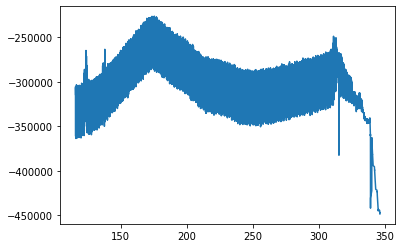

In [17]:
plt.plot(data_channels_subset_detrended["time_seconds"][15000:45000], data_channels_subset_detrended["eog0"][15000:45000])

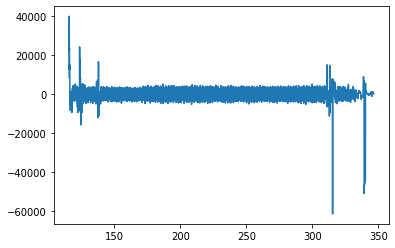

In [18]:
plt.plot(data_channels_subset_detrended["time_seconds"][15000:45000], signal_filter_butterworth(data_channels_subset_detrended["eog0"][15000:45000], 250, 0.5, 10))

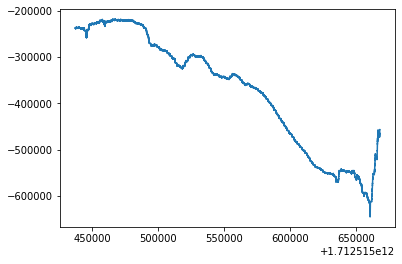

In [19]:
plt.plot(data_channels_subset_detrended["timestamp"][15000:45000], data_channels_subset_detrended["eeg1"][15000:45000])

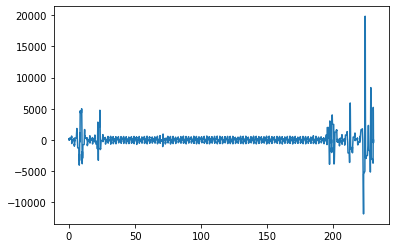

In [20]:
plt.plot(data_channels_subset_detrended["time_seconds"][0:30000], signal_filter_butterworth(data_channels_subset_detrended["eeg0"][15000:45000], 250, 0.5, 10))

In [21]:
study_labels_subset

,timestamp,time_seconds,instruction,blink_instruction,lightblink_instruction,longblink_instruction,gazeLR_instruction,gazeLeft_instruction,gazeRight_instruction,rest_instruction
0,1712515321486,0.000,None,0,0,0,0,0,0,0
1,1712515321486,0.000,lightblink,1,1,0,0,0,0,0
2,1712515321486,0.000,None,0,0,0,0,0,0,0
3,1712515322045,0.559,white,0,0,0,0,0,0,0
4,1712515325044,3.558,lightblink,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
742,1712517791619,2470.133,None,0,0,0,0,0,0,0
743,1712518013032,2691.546,GetReady,0,0,0,0,0,0,0
744,1712518024033,2702.547,VisualMemoryTask,0,0,0,0,0,0,0
745,1712518546879,3225.393,None,0,0,0,0,0,0,0


In [22]:
study_labels_subset["instruction"].unique()

array([None, 'lightblink', 'white', 'rest', 'longblink', 'gazeright',
       'gazeleft', 'Rest', '3minBreak', 'blink study', '5minBreak',
       'Categories', 'White', 'Whale', 'Seal', 'Shrimp', 'Crab',
       'JellyFish', 'Octopus', 'Starfish', 'Eel', 'Tuna', 'Shark',
       'Squid', 'Oyster', 'ElectricGuitar', 'Violin', 'Accordion',
       'Piano', 'Trumpet', 'Saxophone', 'Cello', 'Clarinet', 'Harp',
       'Flute', 'Oboe', 'Beijing', 'Paris', 'Seoul', 'Tokyo', 'Berlin',
       'Madrid', 'Rome', 'Bangkok', 'AbuDhabi', 'London', 'Jakarta',
       'Sidney', 'RecallTest', 'GetReady', 'VisualMemoryTask'],
      dtype=object)

# IV. Merge EOG/EEG Data and Study Label

In [23]:
def create_label(row, specifiedLabel_seconds, time_window): # Calculate nearest index
    nearest_idx = np.argmin(np.abs(specifiedLabel_seconds - row['time_seconds']))
    if not (0 <= nearest_idx < len(specifiedLabel_seconds)):
        return 0  # Invalid nearest index
    
    if abs(row['time_seconds'] - specifiedLabel_seconds.iloc[nearest_idx]) <= time_window:
        return 1
    else:
        return 0

In [24]:
# Task 2: Create a copy of data_channels and name it merged_data
merged_data = data_channels_subset.copy()
merged_data = merged_data[merged_data["time_seconds"]>=0]
time_window = 0.5

study_labels_subset.reset_index(drop=True, inplace=True)
merged_data.reset_index(drop=True, inplace=True)

##################################LABEL: BLINK############################################
blink = study_labels_subset[study_labels_subset["blink_instruction"]==1]
blink_timestamps = blink['time_seconds']

merged_data['blinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

##################################LABEL: BLINK############################################
#blink = study_labels_subset[study_labels_subset["lightblink_instruction"]==1]
#blink_timestamps = blink['time_seconds']

#merged_data['lightblinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

##################################LABEL: BLINK############################################
#blink = study_labels_subset[study_labels_subset["longblink_instruction"]==1]
#blink_timestamps = blink['time_seconds']

#merged_data['longblinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

##################################LABEL: GAZELR ############################################
gazeLR = study_labels_subset[study_labels_subset["gazeLR_instruction"]==1]
gazeLR_timestamps = gazeLR['time_seconds']
merged_data['gazeLRLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

##################################LABEL: GAZELEFT ############################################
gazeLR = study_labels_subset[study_labels_subset["gazeLeft_instruction"]==1]
gazeLR_timestamps = gazeLR['time_seconds']
merged_data['gazeLeftLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

##################################LABEL: GAZELRIGHT ############################################
gazeLR = study_labels_subset[study_labels_subset["gazeRight_instruction"]==1]
gazeLR_timestamps = gazeLR['time_seconds']
merged_data['gazeRightLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

##################################LABEL: REST ############################################
rest = study_labels_subset[study_labels_subset["rest_instruction"]==1]
rest_timestamps = rest['time_seconds']
merged_data['restLabel'] = merged_data.apply(lambda row: create_label(row, rest_timestamps, time_window), axis=1)

In [25]:
pd.reset_option('display.max_rows')
print(merged_data.iloc[:80, :])

        timestamp           eeg0          eeg1           eog0  subject  \
0   1712515321620 -365699.454982 -29653.204610 -498763.570899        8   
1   1712515321624 -365568.826788 -30019.628214 -498694.970810        8   
2   1712515321628 -365743.198594 -29592.051817 -498578.370721        8   
3   1712515321632 -366051.570400 -29124.475421 -498458.770631        8   
4   1712515321636 -366017.942206 -29402.899025 -498375.170542        8   
..            ...            ...           ...            ...      ...   
75  1712515321920 -371733.340437 -24396.974896 -491274.564212        8   
76  1712515321924 -371951.712243 -23946.398500 -491270.964123        8   
77  1712515321928 -371917.084050 -24018.822104 -491132.364033        8   
78  1712515321932 -371772.455856 -24401.245708 -490944.763944        8   
79  1712515321936 -371941.827662 -24148.669312 -490889.163855        8   

    session  time_seconds  blinkLabel  gazeLRLabel  gazeLeftLabel  \
0         0         0.134           1     

In [26]:
merged_data

,timestamp,eeg0,eeg1,eog0,subject,session,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
0,1712515321620,-3.656995e+05,-2.965320e+04,-4.987636e+05,8,0,0.134,1,0,0,0,0
1,1712515321624,-3.655688e+05,-3.001963e+04,-4.986950e+05,8,0,0.138,1,0,0,0,0
2,1712515321628,-3.657432e+05,-2.959205e+04,-4.985784e+05,8,0,0.142,1,0,0,0,0
3,1712515321632,-3.660516e+05,-2.912448e+04,-4.984588e+05,8,0,0.146,1,0,0,0,0
4,1712515321636,-3.660179e+05,-2.940290e+04,-4.983752e+05,8,0,0.150,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
421915,1712518564992,-1.385099e+06,-1.199440e+06,-1.565198e+06,8,0,3243.506,0,0,0,0,0
421916,1712518564996,-1.384809e+06,-1.199385e+06,-1.565019e+06,8,0,3243.510,0,0,0,0,0
421917,1712518565000,-1.385419e+06,-1.199057e+06,-1.565552e+06,8,0,3243.514,0,0,0,0,0
421918,1712518565004,-1.385418e+06,-1.198632e+06,-1.565755e+06,8,0,3243.518,0,0,0,0,0


In [27]:
prepared_data_channels = merged_data.loc[:, ["timestamp", "eeg0", "eeg1", "eog0", "time_seconds", "blinkLabel","gazeLRLabel", "gazeLeftLabel", "gazeRightLabel", "restLabel"]]

prepared_data_channels

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
0,1712515321620,-3.656995e+05,-2.965320e+04,-4.987636e+05,0.134,1,0,0,0,0
1,1712515321624,-3.655688e+05,-3.001963e+04,-4.986950e+05,0.138,1,0,0,0,0
2,1712515321628,-3.657432e+05,-2.959205e+04,-4.985784e+05,0.142,1,0,0,0,0
3,1712515321632,-3.660516e+05,-2.912448e+04,-4.984588e+05,0.146,1,0,0,0,0
4,1712515321636,-3.660179e+05,-2.940290e+04,-4.983752e+05,0.150,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
421915,1712518564992,-1.385099e+06,-1.199440e+06,-1.565198e+06,3243.506,0,0,0,0,0
421916,1712518564996,-1.384809e+06,-1.199385e+06,-1.565019e+06,3243.510,0,0,0,0,0
421917,1712518565000,-1.385419e+06,-1.199057e+06,-1.565552e+06,3243.514,0,0,0,0,0
421918,1712518565004,-1.385418e+06,-1.198632e+06,-1.565755e+06,3243.518,0,0,0,0,0


In [28]:
study_labels_subset.columns

Index(['timestamp', 'time_seconds', 'instruction', 'blink_instruction',
       'lightblink_instruction', 'longblink_instruction', 'gazeLR_instruction',
       'gazeLeft_instruction', 'gazeRight_instruction', 'rest_instruction'],
      dtype='object')

In [29]:
prepared_study_labels = study_labels_subset.loc[:,["timestamp", "time_seconds", "instruction", "blink_instruction", "gazeLeft_instruction", "gazeRight_instruction", "gazeLR_instruction","rest_instruction"]]
prepared_study_labels

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
0,1712515321486,0.000,None,0,0,0,0,0
1,1712515321486,0.000,lightblink,1,0,0,0,0
2,1712515321486,0.000,None,0,0,0,0,0
3,1712515322045,0.559,white,0,0,0,0,0
4,1712515325044,3.558,lightblink,1,0,0,0,0
...,...,...,...,...,...,...,...,...
742,1712517791619,2470.133,None,0,0,0,0,0
743,1712518013032,2691.546,GetReady,0,0,0,0,0
744,1712518024033,2702.547,VisualMemoryTask,0,0,0,0,0
745,1712518546879,3225.393,None,0,0,0,0,0


In [30]:
prepared_study_labels["instruction"].values

array([None, 'lightblink', None, 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'lightblink', 'white', 'lightblink',
       'white', 'lightblink', 'white', 'lightblink', 'white',
       'lightblink', 'white', 'l

Idea: 
Phase1: Take out all row[rest, rest+1], Stop until 'blink study'
Phase2: ["Whale"~ "Sidney"] //Add white after 'Sidney'
Phase3: ["RecallTest ~5minBreak"]
Phase4: ["GetReady"]
Phase5: ["VisualMemoryTask ~"]

In [31]:
#instruction_df = study_labels_subset[['time_seconds', 'instruction']]

# Merge instruction_df with merged_data using left join to keep all rows in merged_data
#merged_data_instruction = pd.merge(merged_data, study_labels_subset, on='timestamp', how = "inner")
#merged_data_instruction = pd.merge(merged_data, instruction_df, on='timestamp', how='outer', tolerance=pd.Timedelta(seconds=0.001))

In [32]:
prepared_data_channels

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
0,1712515321620,-3.656995e+05,-2.965320e+04,-4.987636e+05,0.134,1,0,0,0,0
1,1712515321624,-3.655688e+05,-3.001963e+04,-4.986950e+05,0.138,1,0,0,0,0
2,1712515321628,-3.657432e+05,-2.959205e+04,-4.985784e+05,0.142,1,0,0,0,0
3,1712515321632,-3.660516e+05,-2.912448e+04,-4.984588e+05,0.146,1,0,0,0,0
4,1712515321636,-3.660179e+05,-2.940290e+04,-4.983752e+05,0.150,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
421915,1712518564992,-1.385099e+06,-1.199440e+06,-1.565198e+06,3243.506,0,0,0,0,0
421916,1712518564996,-1.384809e+06,-1.199385e+06,-1.565019e+06,3243.510,0,0,0,0,0
421917,1712518565000,-1.385419e+06,-1.199057e+06,-1.565552e+06,3243.514,0,0,0,0,0
421918,1712518565004,-1.385418e+06,-1.198632e+06,-1.565755e+06,3243.518,0,0,0,0,0


In [179]:
#merged_data_instruction #[merged_data_instruction["instruction"] =='blink study']

# V. Subset Data

## Subset data: Phase1 blinkGaze Study

In [182]:
#index_study = prepared_data_channels[prepared_data_channels["instruction"] =='blink study'].index.values[0]
#timestamp = prepared_data_channels[prepared_data_channels["instruction"] =='blink study'].timestamp.values[0]
#prepared_data_channels_blinkGazeStudy = prepared_data_channels[:index_study]
#prepared_data_channels_blinkGazeStudy

In [33]:
index_study = prepared_study_labels[prepared_study_labels["instruction"] =='blink study'].index.values[0]
timestamp = prepared_study_labels[prepared_study_labels["instruction"] =='blink study'].timestamp.values[0]
prepared_study_labels_blinkGazeStudy = prepared_study_labels[:index_study]


timestamp = prepared_study_labels[prepared_study_labels["instruction"] =='blink study'].timestamp.values[0]
diff = abs(prepared_data_channels["timestamp"] -timestamp) 
index_data = prepared_data_channels[diff==diff.min()].index.values[0]
prepared_data_channels_blinkGazeStudy = prepared_data_channels[:index_data]

In [34]:
prepared_data_channels_blinkGazeStudy

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
0,1712515321620,-365699.454982,-29653.204610,-498763.570899,0.134,1,0,0,0,0
1,1712515321624,-365568.826788,-30019.628214,-498694.970810,0.138,1,0,0,0,0
2,1712515321628,-365743.198594,-29592.051817,-498578.370721,0.142,1,0,0,0,0
3,1712515321632,-366051.570400,-29124.475421,-498458.770631,0.146,1,0,0,0,0
4,1712515321636,-366017.942206,-29402.899025,-498375.170542,0.150,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
213385,1712516961512,436275.095481,489035.666293,423942.783046,1640.026,0,0,0,0,0
213386,1712516961516,436316.723675,488759.242689,443931.383135,1640.030,0,0,0,0,0
213387,1712516961520,436757.351869,488202.819085,457379.983224,1640.034,0,0,0,0,0
213388,1712516961524,436658.980063,488492.395481,441132.583313,1640.038,0,0,0,0,0


In [35]:
prepared_study_labels_blinkGazeStudy

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
0,1712515321486,0.000,None,0,0,0,0,0
1,1712515321486,0.000,lightblink,1,0,0,0,0
2,1712515321486,0.000,None,0,0,0,0,0
3,1712515322045,0.559,white,0,0,0,0,0
4,1712515325044,3.558,lightblink,1,0,0,0,0
...,...,...,...,...,...,...,...,...
634,1712516941027,1619.541,longblink,1,0,0,0,0
635,1712516942025,1620.539,white,0,0,0,0,0
636,1712516945027,1623.541,gazeleft,0,1,0,1,0
637,1712516946026,1624.540,white,0,0,0,0,0


In [36]:
def cut_time_series_by_rest_indices(data, rest_indices):
    cuts = []
    start_index = 0
    
    for end_index in rest_indices:
        if (end_index-start_index > 2):
            cuts.append(data[start_index:end_index])
        start_index = end_index + 1
    
    if start_index < len(data):
        cuts.append(data[start_index:])
    
    return cuts

In [37]:
rest_indices_labels_blinkGazeStudy = prepared_study_labels_blinkGazeStudy[prepared_study_labels_blinkGazeStudy["rest_instruction"] ==1].index
time_series_cuts_labels_blinkGazeStudy = cut_time_series_by_rest_indices(prepared_study_labels_blinkGazeStudy, rest_indices_labels_blinkGazeStudy)

time_series_cuts_labels_blinkGazeStudy[1]

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
93,1712515506049,184.563,longblink,1,0,0,0,0
94,1712515507049,185.563,white,0,0,0,0,0
95,1712515510050,188.564,longblink,1,0,0,0,0
96,1712515511050,189.564,white,0,0,0,0,0
97,1712515514050,192.564,longblink,1,0,0,0,0
...,...,...,...,...,...,...,...,...
178,1712515674055,352.569,white,0,0,0,0,0
179,1712515678054,356.568,longblink,1,0,0,0,0
180,1712515679055,357.569,white,0,0,0,0,0
181,1712515681056,359.570,longblink,1,0,0,0,0


In [38]:
prepared_data_channels_blinkGazeStudy[prepared_data_channels_blinkGazeStudy["restLabel"] ==1].index

Index([ 22465,  22466,  22467,  22468,  22469,  22470,  22471,  22472,  22473,
        22474,
       ...
       212059, 212060, 212061, 212062, 212063, 212064, 212065, 212066, 212067,
       212068],
      dtype='int64', length=1670)

In [39]:
rest_indices_data_channels_blinkGazeStudy = prepared_data_channels_blinkGazeStudy[prepared_data_channels_blinkGazeStudy["restLabel"] ==1].index
time_series_cuts_data_channels_blinkGazeStudy = cut_time_series_by_rest_indices(prepared_data_channels_blinkGazeStudy, rest_indices_data_channels_blinkGazeStudy)

In [40]:
time_series_cuts_data_channels_blinkGazeStudy[0]

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
0,1712515321620,-365699.454982,-29653.204610,-498763.570899,0.134,1,0,0,0,0
1,1712515321624,-365568.826788,-30019.628214,-498694.970810,0.138,1,0,0,0,0
2,1712515321628,-365743.198594,-29592.051817,-498578.370721,0.142,1,0,0,0,0
3,1712515321632,-366051.570400,-29124.475421,-498458.770631,0.146,1,0,0,0,0
4,1712515321636,-366017.942206,-29402.899025,-498375.170542,0.150,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
22460,1712515494532,-261072.887734,-272647.750562,-276034.916611,173.046,0,0,0,0,0
22461,1712515494536,-260571.259540,-273948.174166,-237388.316522,173.050,0,0,0,0,0
22462,1712515494540,-260338.631346,-274285.597770,-237077.716433,173.054,0,0,0,0,0
22463,1712515494544,-260766.003152,-273114.021373,-274689.116344,173.058,0,0,0,0,0


In [41]:
len(time_series_cuts_data_channels_blinkGazeStudy) #20 time series data prepared

12

## Subset data: Phase 2 WordBlink task

In [42]:
study_a = prepared_study_labels[prepared_study_labels["instruction"] =='Whale']
ind_study_a = study_a.index.values[0]
start_study_a = study_a.timestamp.values[0]

study_b = prepared_study_labels[prepared_study_labels["instruction"] =='Sidney']
ind_study_b = study_b.index.values[0]
start_study_b = study_b.timestamp.values[0]

prepared_study_labels_WordBlink = prepared_study_labels[(ind_study_a-1):(ind_study_b+3)]
prepared_study_labels_WordBlink 

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
644,1712517279024,1957.538,White,0,0,0,0,0
645,1712517281023,1959.537,Whale,0,0,0,0,0
646,1712517283023,1961.537,White,0,0,0,0,0
647,1712517286024,1964.538,Seal,0,0,0,0,0
648,1712517288023,1966.537,White,0,0,0,0,0
...,...,...,...,...,...,...,...,...
713,1712517442023,2120.537,Jakarta,0,0,0,0,0
714,1712517444024,2122.538,White,0,0,0,0,0
715,1712517446024,2124.538,Sidney,0,0,0,0,0
716,1712517448023,2126.537,White,0,0,0,0,0


In [43]:
prepared_study_labels_WordBlink.timestamp.values[-1]

1712517450023

In [44]:
timestamp_start = prepared_study_labels_WordBlink.timestamp.values[0]
timestamp_end = prepared_study_labels_WordBlink.timestamp.values[-1]

diff = abs(prepared_data_channels["timestamp"] -timestamp_start) 
index_data_begin = prepared_data_channels[diff==diff.min()].index.values[0]

diff = abs(prepared_data_channels["timestamp"] -timestamp_end) 
index_data_end = prepared_data_channels[diff==diff.min()].index.values[0]

prepared_data_channels_WordBlink = prepared_data_channels[index_data_begin:index_data_end]
prepared_data_channels_WordBlink

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
254600,1712517279300,366234.218715,302948.613567,376164.066686,1957.814,0,0,0,0,0
254601,1712517279304,366307.846909,302853.189963,380376.666775,1957.818,0,0,0,0,0
254602,1712517279308,366266.475103,302848.766359,375887.266864,1957.822,0,0,0,0,0
254603,1712517279312,366183.103297,302891.342755,372518.866953,1957.826,0,0,0,0,0
254604,1712517279316,366215.731491,302831.919151,376212.467043,1957.830,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
276874,1712517449580,302020.434356,191405.798928,309876.862305,2128.094,0,1,1,0,0
276875,1712517449584,302057.062550,191354.375324,312018.462394,2128.098,0,1,1,0,0
276876,1712517449588,301981.690744,191405.951721,312568.062484,2128.102,0,1,1,0,0
276877,1712517449592,301904.318938,191470.528117,311066.662573,2128.106,0,1,1,0,0


## Subset data: Phase 2 Let's Recall task

In [45]:
prepared_study_labels[prepared_study_labels["instruction"] =='RecallTest']

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
732,1712517471023,2149.537,RecallTest,0,0,0,0,0


In [46]:
study_a = prepared_study_labels[prepared_study_labels["instruction"] =='RecallTest']
ind_study_a = study_a.index.values[0]
start_study_a = study_a.timestamp.values[0]

prepared_study_labels_WB_Recall = prepared_study_labels[(ind_study_a):(ind_study_a+3)]
prepared_study_labels_WB_Recall

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
732,1712517471023,2149.537,RecallTest,0,0,0,0,0
733,1712517480349,2158.863,None,0,0,0,0,0
734,1712517712026,2390.540,5minBreak,0,0,0,0,0


In [47]:
timestamp_start = prepared_study_labels_WB_Recall.timestamp.values[0]
timestamp_end = prepared_study_labels_WB_Recall.timestamp.values[-1]

diff = abs(prepared_data_channels["timestamp"] -timestamp_start) 
index_data_begin = prepared_data_channels[diff==diff.min()].index.values[0]

diff = abs(prepared_data_channels["timestamp"] -timestamp_end) 
index_data_end = prepared_data_channels[diff==diff.min()].index.values[0]

prepared_data_channels_WB_Recall = prepared_data_channels[index_data_begin:index_data_end]
prepared_data_channels_WB_Recall

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
279639,1712517471024,295987.182020,169561.858847,302353.940302,2149.538,0,0,0,0,0
279640,1712517471028,296051.810214,169544.435243,306494.540391,2149.542,0,0,0,0,0
279641,1712517471032,296334.438408,169381.011639,307562.140480,2149.546,0,0,0,0,0
279642,1712517471036,296295.066602,169450.588035,302981.740569,2149.550,0,0,0,0,0
279643,1712517471040,296082.694796,169652.164431,300264.340658,2149.554,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
310915,1712517711296,104404.535066,197515.824558,109634.096075,2389.810,0,0,0,0,0
310916,1712517711300,104455.163260,197544.400954,106007.696164,2389.814,0,0,0,0,0
310917,1712517711304,104572.791454,197448.977350,112858.296253,2389.818,0,0,0,0,0
310918,1712517711308,104768.419648,197307.553746,115214.896342,2389.822,0,0,0,0,0


## Subset data: Phase 3 CardGame task

In [48]:
study_a = prepared_study_labels[prepared_study_labels["instruction"] =='VisualMemoryTask']
ind_study_a = study_a.index.values[0]
start_study_a = study_a.timestamp.values[0]

prepared_study_labels_CardGame = prepared_study_labels[(ind_study_a):(ind_study_a+3)]
prepared_study_labels_CardGame

,timestamp,time_seconds,instruction,blink_instruction,gazeLeft_instruction,gazeRight_instruction,gazeLR_instruction,rest_instruction
744,1712518024033,2702.547,VisualMemoryTask,0,0,0,0,0
745,1712518546879,3225.393,None,0,0,0,0,0
746,1712518565011,3243.525,None,0,0,0,0,0


In [49]:
timestamp_start = prepared_study_labels_CardGame.timestamp.values[0]
timestamp_end = prepared_study_labels_CardGame.timestamp.values[-1]

diff = abs(prepared_data_channels["timestamp"] -timestamp_start) 
index_data_begin = prepared_data_channels[diff==diff.min()].index.values[0]

diff = abs(prepared_data_channels["timestamp"] -timestamp_end) 
index_data_end = prepared_data_channels[diff==diff.min()].index.values[0]

prepared_data_channels_CardGame = prepared_data_channels[index_data_begin:index_data_end]
prepared_data_channels_CardGame

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel
351575,1712518024032,-1.414318e+05,-1.006532e+05,-1.351935e+05,2702.546,0,0,0,0,0
351576,1712518024036,-1.414721e+05,-1.006066e+05,-1.366309e+05,2702.550,0,0,0,0,0
351577,1712518024040,-1.415635e+05,-1.005211e+05,-1.374263e+05,2702.554,0,0,0,0,0
351578,1712518024044,-1.415549e+05,-1.005465e+05,-1.369277e+05,2702.558,0,0,0,0,0
351579,1712518024048,-1.414502e+05,-1.006199e+05,-1.360871e+05,2702.562,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
421914,1712518564988,-1.385130e+06,-1.199512e+06,-1.565401e+06,3243.502,0,0,0,0,0
421915,1712518564992,-1.385099e+06,-1.199440e+06,-1.565198e+06,3243.506,0,0,0,0,0
421916,1712518564996,-1.384809e+06,-1.199385e+06,-1.565019e+06,3243.510,0,0,0,0,0
421917,1712518565000,-1.385419e+06,-1.199057e+06,-1.565552e+06,3243.514,0,0,0,0,0


## Subset data: Phase 3 Let's Recall Task

In [53]:
study_a = prepared_study_labels[prepared_study_labels["instruction"] =='RecallTest']
ind_study_a = study_a.index.values[1]

prepared_study_labels_CG_Recall = prepared_study_labels[(ind_study_a):(ind_study_a+3)]
prepared_study_labels_CG_Recall

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
timestamp_start = prepared_study_labels_CG_Recall.timestamp.values[0]
timestamp_end = prepared_study_labels_CG_Recall.timestamp.values[-1]

diff = abs(prepared_data_channels["timestamp"] -timestamp_start) 
index_data_begin = prepared_data_channels[diff==diff.min()].index.values[0]

diff = abs(prepared_data_channels["timestamp"] -timestamp_end) 
index_data_end = prepared_data_channels[diff==diff.min()].index.values[0]

prepared_data_channels_CG_Recall = prepared_data_channels[index_data_begin:index_data_end]
prepared_data_channels_CG_Recall

In [ ]:
study_labels_subset["instruction"].unique()

In [ ]:
# Specify the file path where you want to save the CSV file
file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_data_blinkGaze.csv'
prepared_data_channels_blinkGazeStudy.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_label_blinkGaze.csv'
prepared_study_labels_blinkGazeStudy.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_data_wordBlink.csv'
prepared_data_channels_WordBlink.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_label_wordBlink.csv'
prepared_study_labels_WordBlink.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_data_WB_Recall.csv'
prepared_data_channels_WB_Recall.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_label_WB_Recall.csv'
prepared_study_labels_WB_Recall.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_data_cardGame.csv'
prepared_data_channels_CardGame.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_label_cardGame.csv'
prepared_data_channels_CardGame.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_data_CG_Recall.csv'
prepared_data_channels_CG_Recall.to_csv(file_path, index=False) 

file_path = f'data_analysis/data_BlinkGaze/sub{subject_number}s0/{subject_number}_label_CG_Recall.csv'
prepared_study_labels_CG_Recall.to_csv(file_path, index=False) 